## GLM and GAM Analysis
#Sapasap
#Malatuba
#Canete

In [15]:
#LIBRARIES NEEDED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gamma as SM_Gamma, Gaussian as SM_Gaussian, Binomial
from statsmodels.genmod.families.links import log as log_link, identity as id_link, logit
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from pygam import LinearGAM, GammaGAM, LogisticGAM, s, te, l
import geopandas as gpd
from shapely.geometry import Point
from scipy.interpolate import griddata
from pygam import GAM
from pygam import LogisticGAM, s
from functools import reduce
import operator

#Data Load and Cleaning

In [3]:
# Load the dataset
df = pd.read_csv("PHL_GATS_2021_Public_use_16NOV2023.csv")

# Display dataset info and first few rows
display(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466 entries, 0 to 18465
Columns: 453 entries, FIID to gatsweight
dtypes: float64(338), int64(100), object(15)
memory usage: 63.8+ MB


C:\Users\John Paul\AppData\Local\Temp\ipykernel_13760\1632372540.py:2: DtypeWarning: Columns (150,163,206,230,247,255,269,318,338,350,362,379,401) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("PHL_GATS_2021_Public_use_16NOV2023.csv")


None

,FIID,Selectee,HH1,HH2,HH2A,HH4B01,HH4B02,HH4B03,HH4B04,HH4B05,...,HH4C,HH4CYEAR,HH4D,HH4E,AGE,PROVINCE,StratumID,gatsstrata,gatscluster,gatsweight
0,321174,1,12,4,0.0,66,19.0,18.0,15.0,NaN,...,NaN,NaN,2,2,15,ZAMBOANGA CITY,97332,97332,952,185.888702
1,321052,2,5,3,0.0,45,51.0,22.0,NaN,NaN,...,NaN,NaN,2,2,22,CITY OF NAVOTAS,137503,137503,68,827.788328
2,321118,2,3,3,NaN,49,46.0,20.0,NaN,NaN,...,NaN,NaN,2,2,22,CAMARINES NORTE,51600,51600,483,3430.147883
3,321176,2,5,4,0.0,52,51.0,34.0,18.0,NaN,...,NaN,NaN,2,2,18,ZAMBOANGA CITY,97332,97332,921,645.674896
4,321168,1,4,4,NaN,62,64.0,43.0,28.0,NaN,...,NaN,NaN,2,2,23,ZAMBOANGA CITY,97332,97332,945,620.266393


In [ ]:
# Select relevant columns (way balo ano gidman relevant di)
cols = ["A03", "A04", "AA06", "A05", "EC1", "EC2", "HTP1", "HTP2", "B01"]
df = df[cols].copy()

# Encode categorical variables
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

# Drop missing values
df = df.dropna()

# Show cleaned dataset
df.describe().T


,count,mean,std,min,25%,50%,75%,max
A03,13.0,40.769231,14.184227,21.0,29.0,40.0,55.0,62.0
A04,13.0,10.692308,4.230536,4.0,6.0,14.0,14.0,14.0
AA06,13.0,1.153846,5.014083,-9.0,1.0,2.0,3.0,9.0
A05,13.0,2.769231,1.589227,1.0,2.0,2.0,3.0,7.0
EC1,13.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EC2,13.0,2.923077,0.277350,2.0,3.0,3.0,3.0,3.0
HTP1,13.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
HTP2,13.0,2.230769,2.773501,-7.0,3.0,3.0,3.0,3.0
B01,13.0,2.769231,0.599145,1.0,3.0,3.0,3.0,3.0


#Columns Correlation Analysis

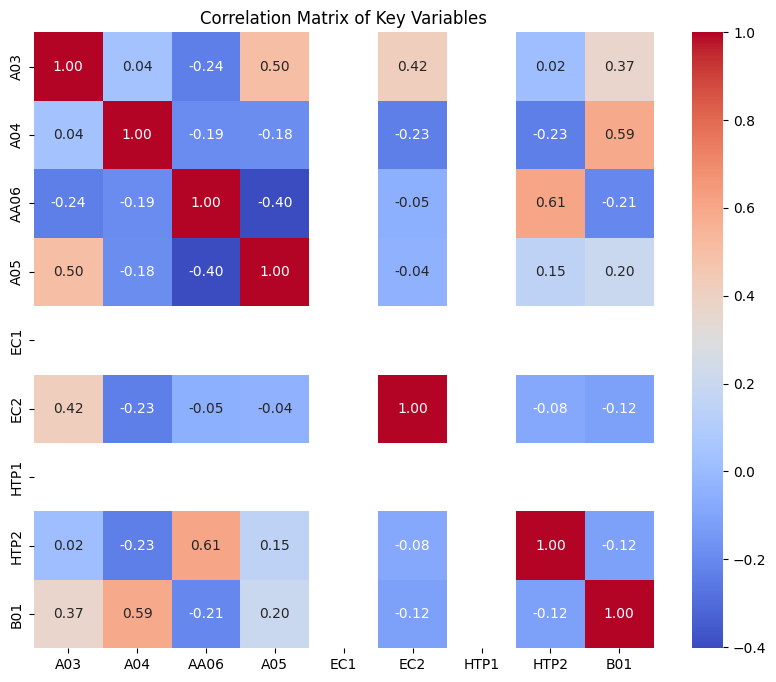

In [ ]:
# Correlation matrix
corr_matrix = df.corr()

# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.show()


## Model 1: Generalized Linear Model (GLM)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    B01   No. Observations:                   13
Model:                            GLM   Df Residuals:                        6
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sun, 19 Oct 2025   Deviance:                       1733.3
Time:                        20:47:29   Pearson chi2:                 2.03e+17
No. Iterations:                     3   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A03          2.14e+14   1.97e+06   1.09e+08      0.0

c:\Users\John Paul\Desktop\termpaper\.venv\lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\John Paul\Desktop\termpaper\.venv\lib\site-packages\statsmodels\genmod\families\family.py:1057: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights


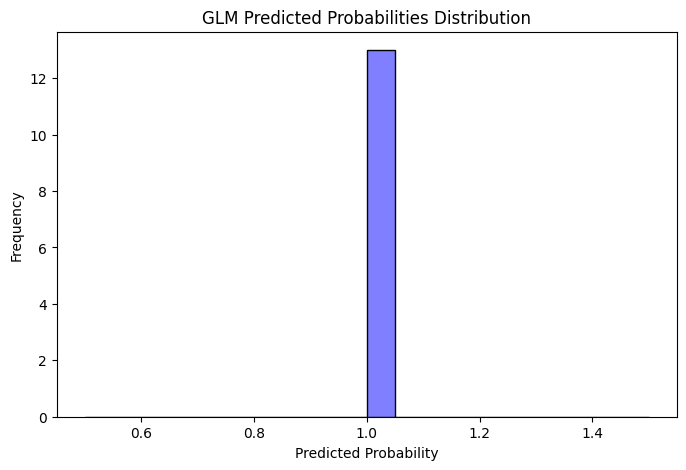

In [ ]:
# X and y (change ta sa appropriate target variable)
y = df["B01"]
X = df.drop(columns=["B01"])
X_glm = sm.add_constant(X)

# Train GLM (Logistic Regression)
glm_model = sm.GLM(y, X_glm, family=sm.families.Binomial()).fit()

# Display GLM summary
print(glm_model.summary())

# Predict using GLM
df["glm_pred"] = glm_model.predict(X_glm)

# Visualize GLM prediction distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["glm_pred"], kde=True, bins=20, color="blue")
plt.title("GLM Predicted Probabilities Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


## Model 2: Generalized Additive Model (GAM)

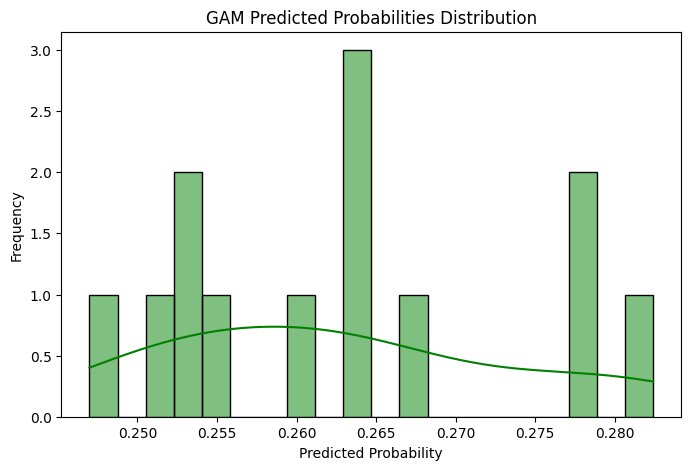

In [ ]:
# Ensure y is binary (1 = smoker, 0 = non-smoker)
y_binary = df["B01"].apply(lambda x: 1 if x in [1, 2] else 0)

# Build GAM terms safely using reduce
terms = reduce(operator.add, [s(i) for i in range(X.shape[1])])

# Initialize and fit GAM
gam_model = LogisticGAM(terms=terms).fit(X.values, y_binary.values)

# Predict probabilities
df["gam_pred"] = np.ravel(gam_model.predict_mu(X.values))

# Visualization
plt.figure(figsize=(8, 5))
sns.histplot(df["gam_pred"], kde=True, bins=20, color="green")
plt.title("GAM Predicted Probabilities Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

## Visual Comparison: GLM vs. GAM

C:\Users\John Paul\AppData\Local\Temp\ipykernel_13760\3585296623.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df["glm_pred"], label="GLM Predictions", fill=True, alpha=0.6)


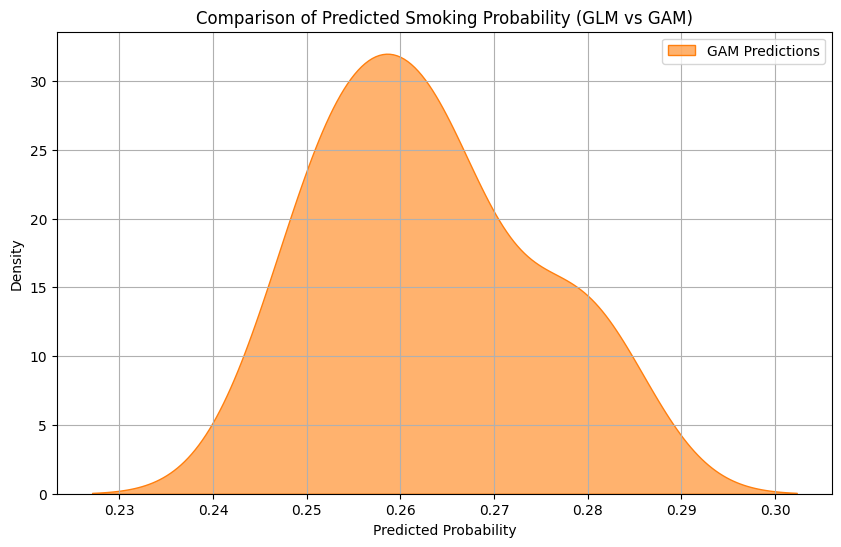

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df["glm_pred"], label="GLM Predictions", fill=True, alpha=0.6)
sns.kdeplot(df["gam_pred"], label="GAM Predictions", fill=True, alpha=0.6)
plt.title("Comparison of Predicted Smoking Probability (GLM vs GAM)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


#Track Model Change

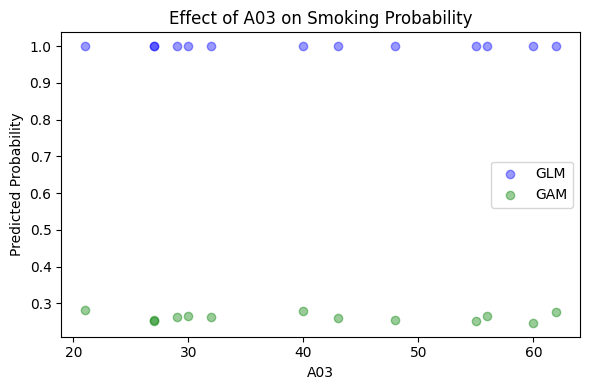

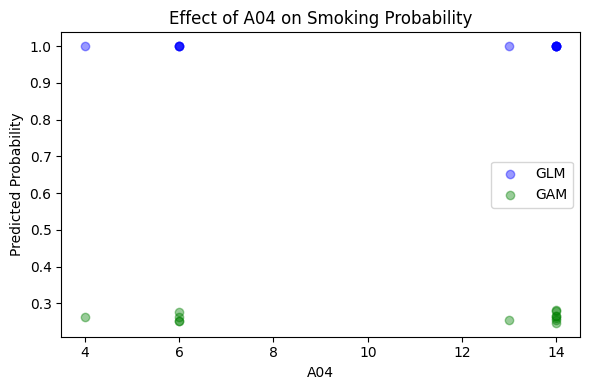

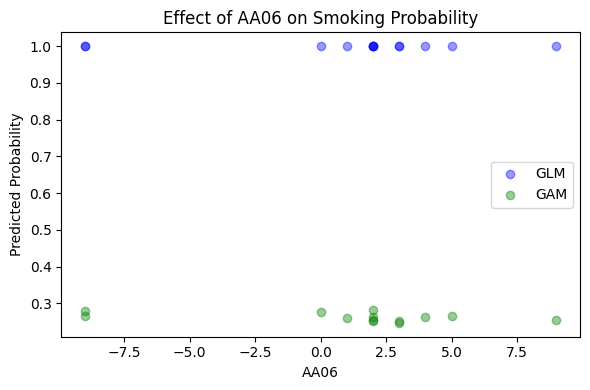

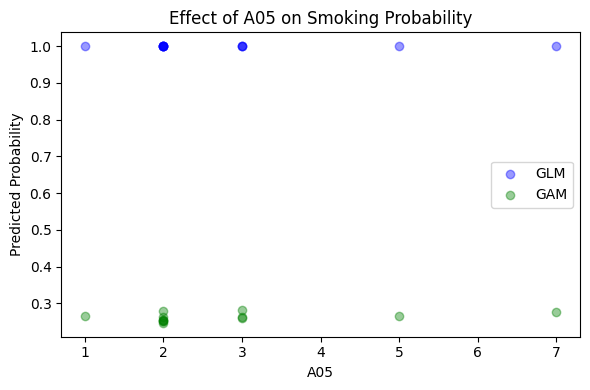

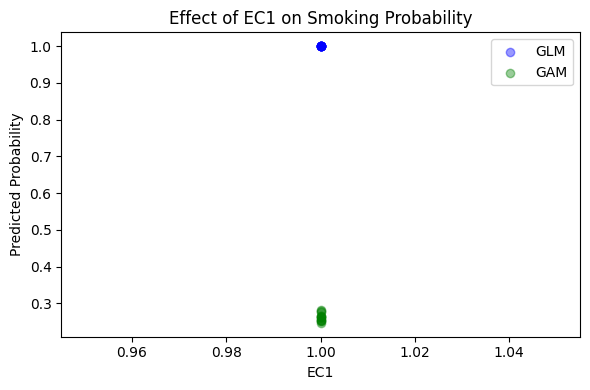

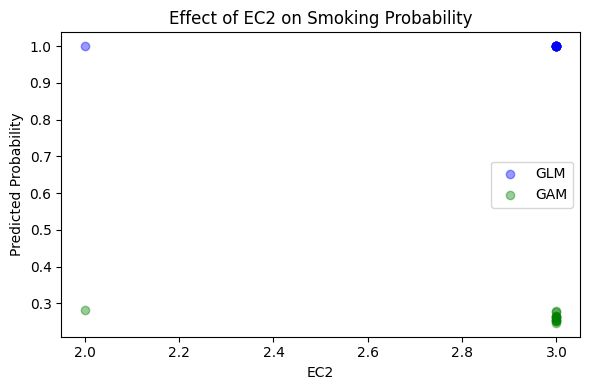

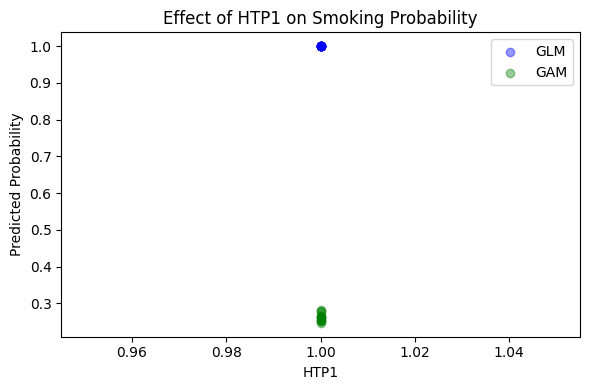

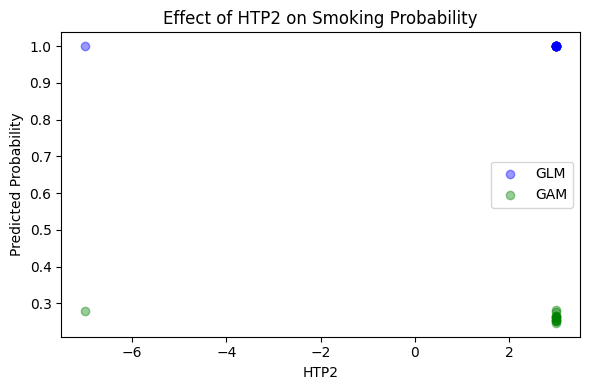

In [19]:
# Visualizing how each model reacts to correlated features
for feature in X.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[feature], df["glm_pred"], color="blue", alpha=0.4, label="GLM")
    plt.scatter(df[feature], df["gam_pred"], color="green", alpha=0.4, label="GAM")
    plt.title(f"Effect of {feature} on Smoking Probability")
    plt.xlabel(feature)
    plt.ylabel("Predicted Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()


#GAM Partial Dependence Plots

ValueError: cannot create grid for intercept term

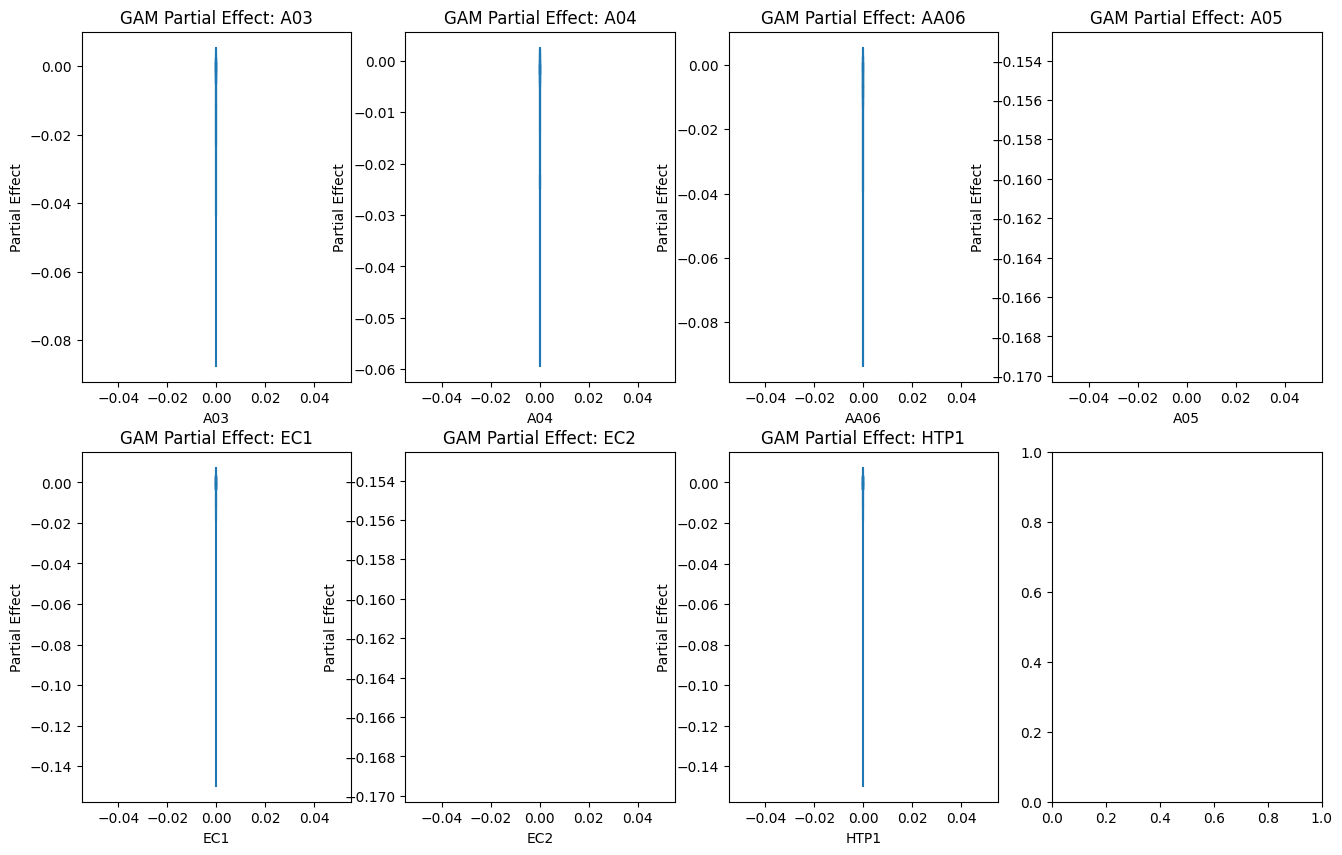

In [20]:
plt.figure(figsize=(16, 10))
for i, term in enumerate(gam_model.terms[1:], start=1):  # skip intercept
    plt.subplot(2, 4, i)
    XX = gam_model.generate_X_grid(term=i)
    plt.plot(XX[:, i-1], gam_model.partial_dependence(term=i))
    plt.title(f"GAM Partial Effect: {X.columns[i-1]}")
    plt.xlabel(X.columns[i-1])
    plt.ylabel("Partial Effect")

plt.tight_layout()
plt.show()


#Summary of Model Difference

In [21]:
glm_mean = df["glm_pred"].mean()
gam_mean = df["gam_pred"].mean()

print(f"Average predicted probability (GLM): {glm_mean:.3f}")
print(f"Average predicted probability (GAM): {gam_mean:.3f}")
print(f"Difference: {abs(glm_mean - gam_mean):.3f}")


Average predicted probability (GLM): 1.000
Average predicted probability (GAM): 0.263
Difference: 0.737
